## Get Data

In [12]:
from sklearn.datasets import fetch_olivetti_faces

data = fetch_olivetti_faces()
import numpy as np

Let's get to know the data by exploring the type and viewing some of the methods built in.

In [2]:
type(data)

sklearn.utils.Bunch

In [3]:
help(data)

Help on Bunch in module sklearn.utils object:

class Bunch(builtins.dict)
 |  Bunch(**kwargs)
 |  
 |  Container object exposing keys as attributes.
 |  
 |  Bunch objects are sometimes used as an output for functions and methods.
 |  They extend dictionaries by enabling values to be accessed by key,
 |  `bunch["value_key"]`, or by an attribute, `bunch.value_key`.
 |  
 |  Examples
 |  --------
 |  >>> from sklearn.utils import Bunch
 |  >>> b = Bunch(a=1, b=2)
 |  >>> b['b']
 |  2
 |  >>> b.b
 |  2
 |  >>> b.a = 3
 |  >>> b['a']
 |  3
 |  >>> b.c = 6
 |  >>> b['c']
 |  6
 |  
 |  Method resolution order:
 |      Bunch
 |      builtins.dict
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __dir__(self)
 |      Default dir() implementation.
 |  
 |  __getattr__(self, key)
 |  
 |  __init__(self, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __setattr__(self, key, value)
 |      Implement setattr(self, name, value).
 |  
 |  __se

In [4]:
data.keys()

dict_keys(['data', 'images', 'target', 'DESCR'])

In [5]:
data['data'].shape

(400, 4096)

In [6]:
data['target'].shape

(400,)

What are the target variables?

In [7]:
type(data['target'])

numpy.ndarray

In [13]:
np.unique(data['target'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])

Ok there are 400 different data points and 40 different target values. My assumption is that each target has 10 data points. Let's see if that is true.

In [16]:
values, counts = np.unique(data['target'], return_counts = True)
for val, count in zip(values, counts):
    print(val, count)

0 10
1 10
2 10
3 10
4 10
5 10
6 10
7 10
8 10
9 10
10 10
11 10
12 10
13 10
14 10
15 10
16 10
17 10
18 10
19 10
20 10
21 10
22 10
23 10
24 10
25 10
26 10
27 10
28 10
29 10
30 10
31 10
32 10
33 10
34 10
35 10
36 10
37 10
38 10
39 10


Looks like the assumption was correct. We need to worry about splitting the data in a strified fashion. Reading the documentation for [train_test_split](#https://stackoverflow.com/questions/29438265/stratified-train-test-split-in-scikit-learn) shows that we can stratify using the stratify attribute.

## Split Data

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['data'], data['target'], train_size = 0.5, stratify = data['target'])

Let's make sure the class balance is similar accross the two datasets.

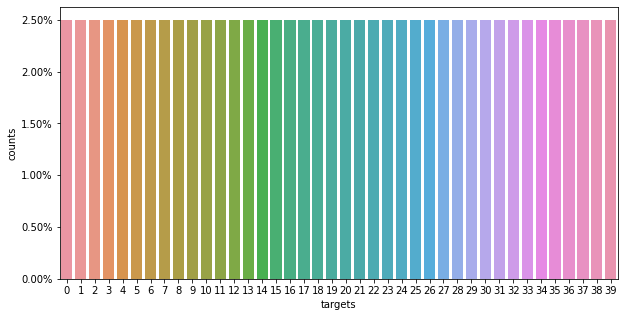

In [37]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import matplotlib.ticker as mtick

y_train_values, y_train_counts = np.unique(y_train, return_counts = True)
n_train = y_train.shape[0]
y_train_counts = y_train_counts / n_train

fig, axs = plt.subplots(1,1)
fig.set_size_inches(10,5)

df_target_counts = pd.DataFrame(data = {'targets' : y_train_values, 'counts' : y_train_counts})

g = sns.barplot(data = df_target_counts, x = 'targets', y = 'counts')

axs.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

## Visualize 25 Faces

From the description of the assignment, we know that the images are flattened but are supposed to be 64 by 64. Let's visualize the first image, then 25 at once.

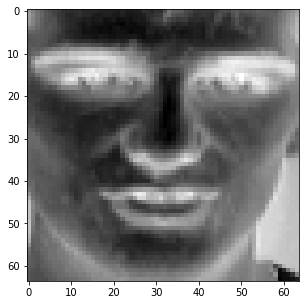

In [23]:
fig, axs = plt.subplots(1,1)
fig.set_size_inches(5,5)

sample = X_train[0].reshape(64, 64)

plt.imshow(sample, cmap = mpl.cm.binary)
plt.show()

Now let's try to make a 5 by 5 grid of the first 25 faces.

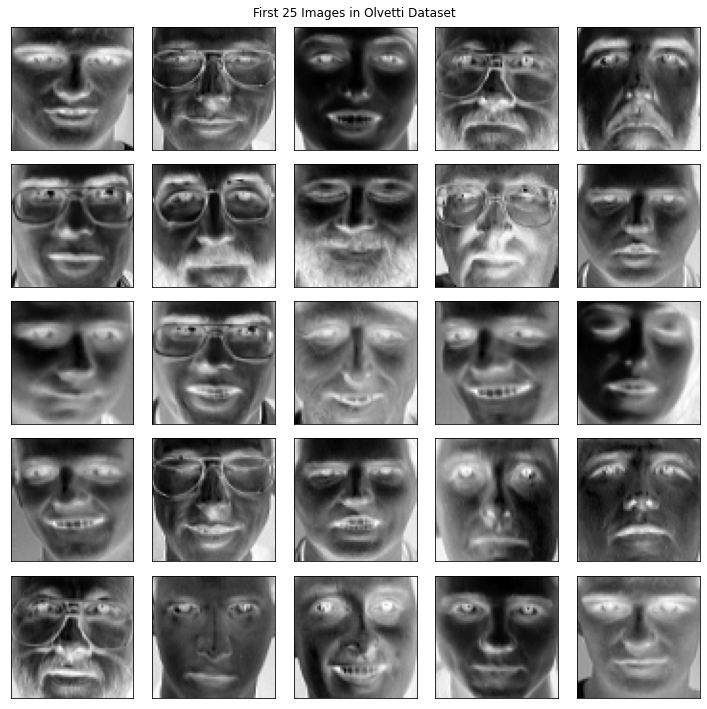

In [24]:
fig, axs = plt.subplots(5,5)

fig.set_size_inches(10,10)

axs = axs.ravel()
for ind in range(25):
    axs[ind].imshow(X_train[ind].reshape(64,64), cmap = mpl.cm.binary)
    axs[ind].set_xticks([])
    axs[ind].set_yticks([])

fig.suptitle('First 25 Images in Olvetti Dataset')
fig.tight_layout()
plt.show()